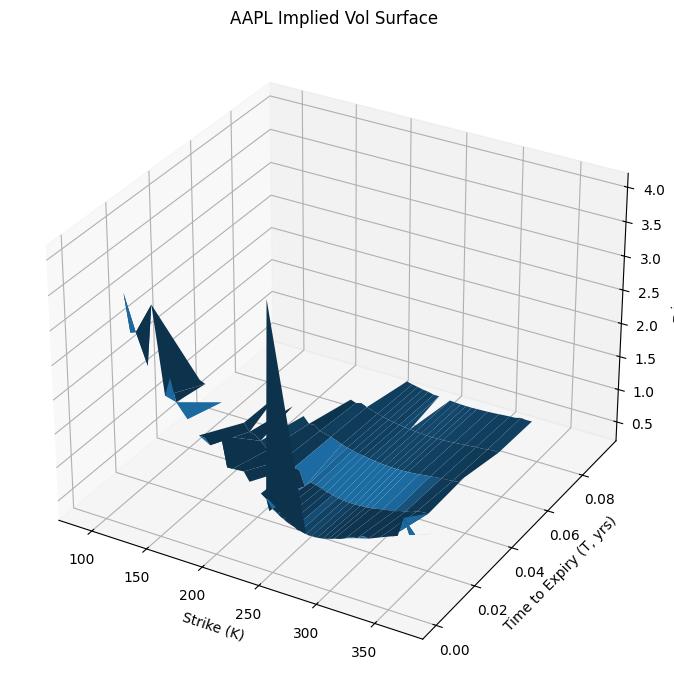

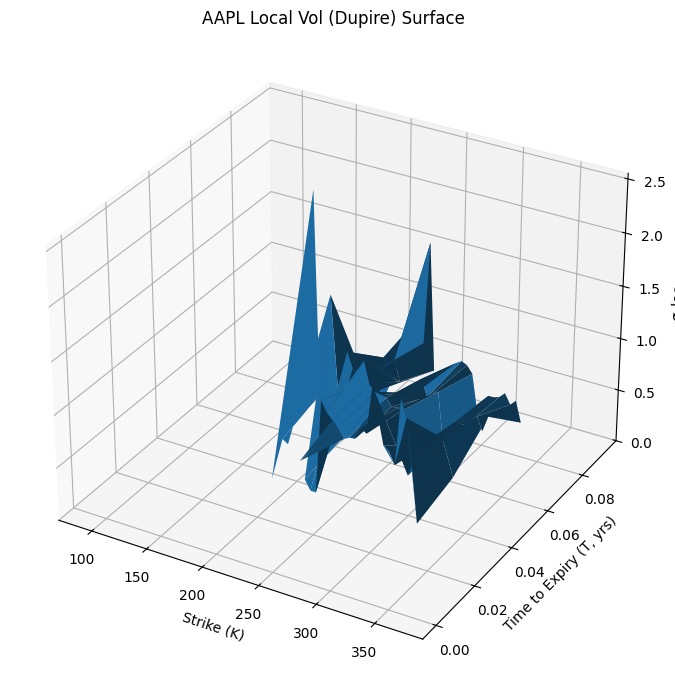

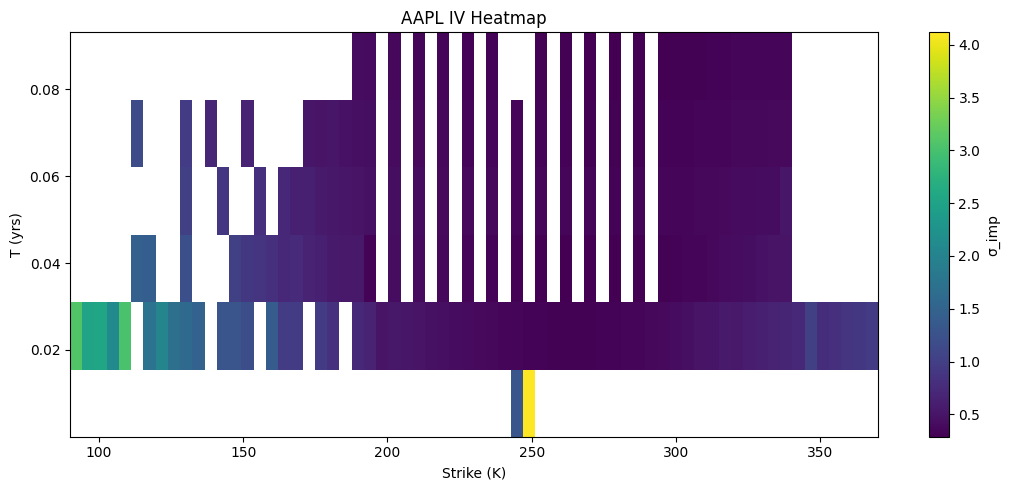

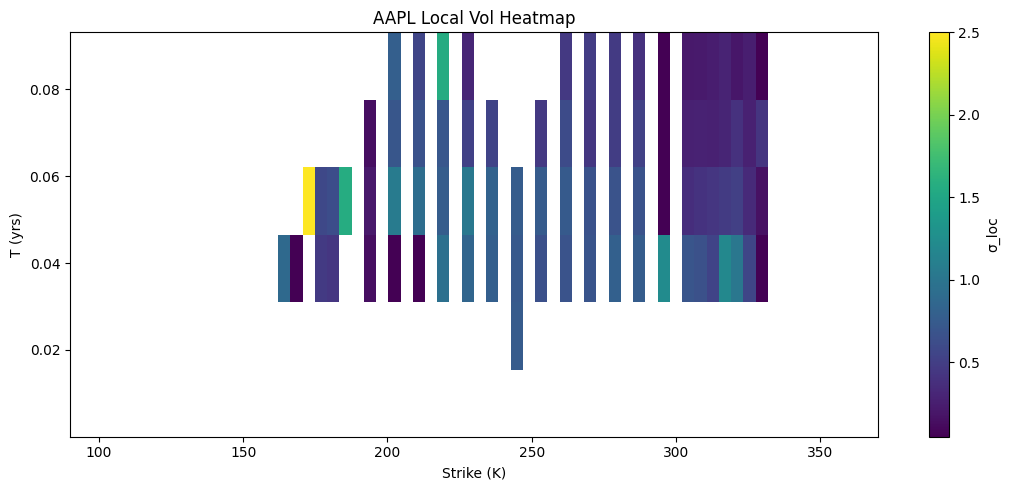

Saved: AAPL_dupire_local_vol_points.csv
          T  strike  iv_imp  call_price  dC_dT  d2C_dK2  sigma_loc
0  0.000001    90.0     NaN         NaN    NaN      NaN        NaN
1  0.000001    95.0     NaN         NaN    NaN      NaN        NaN
2  0.000001   100.0     NaN         NaN    NaN      NaN        NaN
3  0.000001   110.0     NaN         NaN    NaN      NaN        NaN
4  0.000001   115.0     NaN         NaN    NaN      NaN        NaN


In [1]:
# Step 12 — Local Volatility via Dupire from an Implied-Vol Surface
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf
from datetime import datetime, timezone
from scipy.stats import norm

# ---------------- Black–Scholes helpers ---------------- #
def bs_call_price(S, K, T, r, q, sigma):
    if T <= 0:  # maturity payoff under risk-neutral
        return max(S*np.exp(-q*T) - K*np.exp(-r*T), 0.0)
    if sigma <= 0:
        return max(S*np.exp(-q*T) - K*np.exp(-r*T), 0.0)
    d1 = (np.log((S*np.exp(-q*T))/(K*np.exp(-r*T))) + 0.5*sigma*sigma*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*np.exp(-q*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def implied_vol_binary(C_mkt, S, K, T, r=0.02, q=0.0, tol=1e-6, low=1e-6, high=5.0, max_iter=100):
    # simple robust bracketing IV for calls
    intrinsic = max(0.0, S*np.exp(-q*T) - K*np.exp(-r*T))
    if C_mkt < intrinsic - 1e-10:  # stale/bad quote
        return np.nan
    if abs(C_mkt - intrinsic) < 1e-12:
        return 0.0
    lo, hi = low, high
    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        price = bs_call_price(S, K, T, r, q, mid)
        if abs(price - C_mkt) < tol:
            return mid
        if price > C_mkt: hi = mid
        else: lo = mid
    return mid

# ---------------- Build IV surface from Yahoo ---------------- #
def pull_iv_surface(ticker="AAPL", max_expiries=6, r=0.02, q=0.0, prefer_calls=True):
    tk = yf.Ticker(ticker)
    spot_series = tk.history(period="1d")["Close"]
    if spot_series.empty:
        raise SystemExit("No spot data.")
    S = float(spot_series.iloc[-1])
    expiries = tk.options
    if not expiries:
        raise SystemExit("No listed options.")
    expiries = expiries[:max_expiries]

    now = datetime.now(timezone.utc)
    rows = []
    for exp in expiries:
        chain = tk.option_chain(exp)
        calls = chain.calls.copy()
        puts  = chain.puts.copy()
        # compute mid
        for df, side in [(calls, "C"), (puts, "P")]:
            if not df.empty:
                df["mid"] = (df["bid"].fillna(0) + df["ask"].fillna(0))/2.0
                df["side"] = side
        # pick data
        base = None
        if prefer_calls and not calls.empty:
            base = calls
        elif not puts.empty:
            base = puts
        else:
            continue
        base = base.dropna(subset=["mid"])
        if base.empty:
            continue

        T = max((pd.to_datetime(exp).tz_localize("UTC") - now).days/365.0, 1e-6)
        # Compute IV per strike from mid call (or put if chosen)
        ivs = []
        for _, row in base.iterrows():
            K = float(row["strike"])
            Cmid = float(row["mid"])
            iv = implied_vol_binary(Cmid, S, K, T, r=r, q=q)
            ivs.append((K, T, iv))
        frame = pd.DataFrame(ivs, columns=["strike","T","iv"]).dropna()
        rows.append(frame)

    if not rows:
        raise SystemExit("No usable IV points.")
    iv_table = pd.concat(rows, ignore_index=True).dropna()
    # clean/sort
    iv_table = iv_table[(iv_table["iv"]>0) & (iv_table["iv"]<5.0)]
    iv_table = iv_table.sort_values(["T","strike"]).reset_index(drop=True)
    return S, iv_table

# ---------------- Dupire: C(K,T) grid & local vol ---------------- #
def dupire_local_vol_surface(ticker="AAPL", max_expiries=6, r=0.02, q=0.0,
                             clip_sigma_loc=(0.01, 3.0)):
    S, iv_table = pull_iv_surface(ticker=ticker, max_expiries=max_expiries, r=r, q=q)

    # pivot to regular grid (T rows, K cols)
    piv = iv_table.pivot_table(index="T", columns="strike", values="iv")
    T_vals = piv.index.values
    K_vals = piv.columns.values
    sigma_imp = piv.values  # shape (len(T), len(K))

    # compute Black–Scholes call price grid C(K,T) using σ_imp
    C = np.zeros_like(sigma_imp)
    for i, T in enumerate(T_vals):
        for j, K in enumerate(K_vals):
            C[i, j] = bs_call_price(S, K, T, r, q, sigma_imp[i, j])

    # finite-difference derivatives
    # Use nonuniform-safe gradients if needed; here grids are uniform (after pivot)
    # ∂C/∂T (rows); ∂^2 C/∂K^2 (cols twice)
    # Guard against small grid sizes
    if len(T_vals) < 3 or len(K_vals) < 3:
        raise SystemExit("Need at least 3 expiries and 3 strikes for stable second derivatives.")

    # approximate gradients with central differences via numpy.gradient then gradient again
    # scale by actual step sizes
    dT = T_vals[1] - T_vals[0]
    dK = K_vals[1] - K_vals[0]

    dC_dT = np.gradient(C, dT, axis=0)          # ∂C/∂T
    dC_dK  = np.gradient(C, dK, axis=1)         # ∂C/∂K
    d2C_dK2 = np.gradient(dC_dK, dK, axis=1)    # ∂²C/∂K²

    # Dupire local variance: sigma_loc^2 = (∂C/∂T) / (0.5 * K^2 * ∂²C/∂K²)
    K_grid = np.tile(K_vals, (len(T_vals), 1))
    denom = 0.5 * (K_grid**2) * d2C_dK2

    # numerical guards: avoid divide-by-zero / negative curvatures
    eps = 1e-10
    denom_safe = np.where(np.abs(denom) < eps, np.nan, denom)
    sig2 = dC_dT / denom_safe

    # local vol is sqrt of local variance; clip to sane band to suppress spikes
    sigma_loc = np.sqrt(np.clip(sig2, clip_sigma_loc[0]**2, clip_sigma_loc[1]**2))

    # mask NaNs where derivatives unreliable (edges)
    mask = ~np.isfinite(sigma_loc)
    sigma_loc[mask] = np.nan

    # pack results table
    rows = []
    for i, T in enumerate(T_vals):
        for j, K in enumerate(K_vals):
            rows.append((T, K, sigma_imp[i,j], C[i,j], dC_dT[i,j], d2C_dK2[i,j], sigma_loc[i,j]))
    out = pd.DataFrame(rows, columns=["T","strike","iv_imp","call_price","dC_dT","d2C_dK2","sigma_loc"])

    return S, T_vals, K_vals, sigma_imp, sigma_loc, out

# ---------------- Plotting helpers ---------------- #
def plot_surface(K_vals, T_vals, Z, title, zlabel):
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    Tmesh, Kmesh = np.meshgrid(T_vals, K_vals, indexing="ij")
    fig = plt.figure(figsize=(11,7))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(Kmesh, Tmesh, Z, linewidth=0, antialiased=True)
    ax.set_xlabel("Strike (K)")
    ax.set_ylabel("Time to Expiry (T, yrs)")
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    plt.tight_layout(); plt.show()

def plot_heatmap(K_vals, T_vals, Z, title, cbar="Value"):
    plt.figure(figsize=(11,5))
    extent=[K_vals.min(), K_vals.max(), T_vals.min(), T_vals.max()]
    plt.imshow(Z, aspect="auto", origin="lower", extent=extent)
    plt.colorbar(label=cbar)
    plt.xlabel("Strike (K)"); plt.ylabel("T (yrs)"); plt.title(title)
    plt.tight_layout(); plt.show()

# ---------------- Run demo ---------------- #
if __name__ == "__main__":
    ticker = "AAPL"
    r, q = 0.02, 0.0
    S, T_vals, K_vals, sigma_imp, sigma_loc, table = dupire_local_vol_surface(
        ticker=ticker, max_expiries=6, r=r, q=q, clip_sigma_loc=(0.05, 2.5)
    )

    # Visualize implied vol vs local vol
    plot_surface(K_vals, T_vals, sigma_imp, f"{ticker} Implied Vol Surface", "σ_imp")
    plot_surface(K_vals, T_vals, sigma_loc, f"{ticker} Local Vol (Dupire) Surface", "σ_loc")

    # Heatmaps for a quick glance
    plot_heatmap(K_vals, T_vals, sigma_imp, f"{ticker} IV Heatmap", "σ_imp")
    plot_heatmap(K_vals, T_vals, sigma_loc, f"{ticker} Local Vol Heatmap", "σ_loc")

    # Save points
    table.to_csv(f"{ticker}_dupire_local_vol_points.csv", index=False)
    print(f"Saved: {ticker}_dupire_local_vol_points.csv")
    print(table.head())
